In [2]:
import pandas as pd
import numpy as np
import sqlite3

In [4]:
orders=pd.read_csv("sales.csv")
orders.head(5)

,sale_id,branch,city,customer_type,gender,product_name,product_category,unit_price,quantity,tax,total_price,reward_points
0,1,A,New York,Member,Male,Shampoo,Personal Care,5.50,3,1.16,17.66,1
1,2,B,Los Angeles,Normal,Female,Notebook,Stationery,2.75,10,1.93,29.43,0
2,3,A,New York,Member,Female,Apple,Fruits,1.20,15,1.26,19.26,1
3,4,A,Chicago,Normal,Male,Detergent,Household,7.80,5,2.73,41.73,0
4,5,B,Los Angeles,Member,Female,Orange Juice,Beverages,3.50,7,1.72,26.22,2


In [6]:
conn=sqlite3.connect(":memory:")

In [8]:
orders.to_sql('orders',conn,index=False,if_exists='replace')

1000

In [15]:
query1=("select sale_id,reward_points from orders  order by reward_points desc")
pd.read_sql(query1,conn)

,sale_id,reward_points
0,958,43
1,161,42
2,57,41
3,135,41
4,261,40
...,...,...
995,991,0
996,992,0
997,993,0
998,994,0


In [18]:
query2=("select sum(total_price) as Total_revenue from orders")
pd.read_sql(query2,conn)

,Total_revenue
0,118583.9


In [22]:
query3=("select row_number() over (order by branch) as SNO, branch,sum(total_price) as revenue from orders group by branch order by sum(total_price) desc")
pd.read_sql(query3,conn)

,SNO,branch,revenue
0,1,A,82811.64
1,2,B,35772.26


In [25]:
query4=("select product_category,sum(total_price) as revenue from orders group by product_category order by sum(total_price) desc")
pd.read_sql(query4,conn)

,product_category,revenue
0,Personal Care,27050.18
1,Fruits,26197.45
2,Beverages,22983.32
3,Household,21615.84
4,Stationery,20737.11


In [27]:
query5=("select product_category,product_name,sum(total_price) as revenue from orders group by product_name order by sum(total_price) desc")
pd.read_sql(query5,conn)

,product_category,product_name,revenue
0,Personal Care,Shampoo,27041.36
1,Stationery,Notebook,24792.98
2,Beverages,Orange Juice,24686.46
3,Household,Detergent,22449.07
4,Fruits,Apple,19614.03


In [29]:
query6="select avg(quantity) as basket_size from orders"
pd.read_sql(query6,conn)


,basket_size
0,10.337


In [35]:
query7=("select  product_category,product_name,sum(total_price) as revenue,customer_type,city from orders group by product_name order by sum(total_price) desc")
pd.read_sql(query7,conn)

,product_category,product_name,revenue,customer_type,city
0,Personal Care,Shampoo,27041.36,Member,New York
1,Stationery,Notebook,24792.98,Normal,Los Angeles
2,Beverages,Orange Juice,24686.46,Member,Los Angeles
3,Household,Detergent,22449.07,Normal,Chicago
4,Fruits,Apple,19614.03,Member,New York


In [51]:
#high selling product in each branch
query8="select branch,product_name from ( select branch,product_name,sum(total_price) as total_sales ,rank() over (partition by branch order by sum(total_price) desc) as rank from orders group by branch,product_name) ranked_sales where rank=1"
pd.read_sql(query8,conn)


,branch,product_name
0,A,Shampoo
1,B,Orange Juice


In [53]:
query9=("select product_name,quantity from orders group by product_name order by sum(total_price) desc")
pd.read_sql(query9,conn)

,product_name,quantity
0,Shampoo,3
1,Notebook,10
2,Orange Juice,7
3,Detergent,5
4,Apple,15


In [54]:
query10="SELECT city, gender,ROUND(SUM(total_price) * 100.0 / SUM(SUM(total_price)) OVER (PARTITION BY city), 2) AS percentage_contribution FROM orders GROUP BY city, gender ORDER BY city, percentage_contribution DESC"
pd.read_sql(query10,conn)

,city,gender,percentage_contribution
0,Chicago,Male,56.81
1,Chicago,Female,43.19
2,Los Angeles,Male,57.05
3,Los Angeles,Female,42.95
4,New York,Female,50.98
5,New York,Male,49.02


In [62]:
query11="select city,product_category,sum(total_price) as revenue, dense_rank() over (partition by city order by sum(total_price)) as rank from orders group by city,product_category "
pd.read_sql(query11,conn)

,city,product_category,revenue,rank
0,Chicago,Beverages,6431.42,1
1,Chicago,Household,8116.01,2
2,Chicago,Personal Care,8510.49,3
3,Chicago,Fruits,9716.12,4
4,Chicago,Stationery,9810.67,5
5,Los Angeles,Stationery,4141.03,1
6,Los Angeles,Household,6358.20,2
7,Los Angeles,Beverages,8044.45,3
8,Los Angeles,Personal Care,8364.01,4
9,Los Angeles,Fruits,8864.57,5


In [63]:
query12="SELECT sale_id, branch, total_price,ROUND(AVG(total_price) OVER (PARTITION BY branch ORDER BY sale_id ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2) AS moving_avg_sales FROM orders"
pd.read_sql(query12,conn)

,sale_id,branch,total_price,moving_avg_sales
0,1,A,17.66,17.66
1,3,A,19.26,18.46
2,4,A,41.73,26.22
3,6,A,108.24,56.41
4,7,A,11.46,53.81
...,...,...,...,...
995,967,B,70.83,153.73
996,978,B,21.83,70.01
997,980,B,9.33,34.00
998,984,B,23.84,18.33


In [67]:
query13="select branch,sum(total_price) as branch_revenue,round(sum(total_price)-avg(sum(total_price)) over(),2) as deviation_from_avg from orders group by branch"
pd.read_sql(query13,conn)

,branch,branch_revenue,deviation_from_avg
0,A,82811.64,23519.69
1,B,35772.26,-23519.69


In [70]:
df=pd.read_csv("sales.csv")
total_revenue=df['total_price'].sum()
df.head(3)


,sale_id,branch,city,customer_type,gender,product_name,product_category,unit_price,quantity,tax,total_price,reward_points
0,1,A,New York,Member,Male,Shampoo,Personal Care,5.50,3,1.16,17.66,1
1,2,B,Los Angeles,Normal,Female,Notebook,Stationery,2.75,10,1.93,29.43,0
2,3,A,New York,Member,Female,Apple,Fruits,1.20,15,1.26,19.26,1


In [71]:
revenue_branch=df.groupby('branch')['total_price'].sum().sort_values(ascending=False)
revenue_branch

branch
A    82811.64
B    35772.26
Name: total_price, dtype: float64

In [73]:
#missing values
print("missing values\n",df.isnull().sum())

missing values
 sale_id             0
branch              0
city                0
customer_type       0
gender              0
product_name        0
product_category    0
unit_price          0
quantity            0
tax                 0
total_price         0
reward_points       0
dtype: int64


In [78]:
#duplicates
duplicates=df.duplicated().sum()
print(f"duplicates:{duplicates}")
print(df.dtypes)

duplicates:0
sale_id               int64
branch               object
city                 object
customer_type        object
gender               object
product_name         object
product_category     object
unit_price          float64
quantity              int64
tax                 float64
total_price         float64
reward_points         int64
dtype: object


In [83]:
#adding profit margin
df['cost_estimate']=df['unit_price']*0.7*df['quantity']
df['profit_margin']=df['total_price']-df['cost_estimate']
print(df.profit_margin,df.cost_estimate)

0       6.110
1      10.180
2       6.660
3      14.430
4       9.070
        ...  
995     6.305
996     6.324
997    13.262
998    25.762
999     6.082
Name: profit_margin, Length: 1000, dtype: float64 0      11.550
1      19.250
2      12.600
3      27.300
4      17.150
        ...  
995    11.935
996    11.956
997    25.088
998    48.748
999    11.508
Name: cost_estimate, Length: 1000, dtype: float64


In [85]:
df["ponits_efficiency"]=df['reward_points']/df['total_price']
df

,sale_id,branch,city,customer_type,gender,product_name,product_category,unit_price,quantity,tax,total_price,reward_points,cost_estimate,profit_margin,ponits_efficiency
0,1,A,New York,Member,Male,Shampoo,Personal Care,5.50,3,1.16,17.66,1,11.550,6.110,0.056625
1,2,B,Los Angeles,Normal,Female,Notebook,Stationery,2.75,10,1.93,29.43,0,19.250,10.180,0.000000
2,3,A,New York,Member,Female,Apple,Fruits,1.20,15,1.26,19.26,1,12.600,6.660,0.051921
3,4,A,Chicago,Normal,Male,Detergent,Household,7.80,5,2.73,41.73,0,27.300,14.430,0.000000
4,5,B,Los Angeles,Member,Female,Orange Juice,Beverages,3.50,7,1.72,26.22,2,17.150,9.070,0.076278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,A,New York,Member,Female,Shampoo,Stationery,1.55,11,1.19,18.24,1,11.935,6.305,0.054825
996,997,A,New York,Member,Male,Detergent,Personal Care,2.44,7,1.20,18.28,1,11.956,6.324,0.054705
997,998,A,New York,Member,Female,Shampoo,Stationery,17.92,2,2.51,38.35,3,25.088,13.262,0.078227
998,999,A,New York,Member,Female,Shampoo,Beverages,17.41,4,4.87,74.51,7,48.748,25.762,0.093947


In [89]:
print(df.describe(include='all'))

            sale_id branch      city customer_type gender product_name  \
count   1000.000000   1000      1000          1000   1000         1000   
unique          NaN      2         3             2      2            5   
top             NaN      A  New York        Member   Male      Shampoo   
freq            NaN    674       344           516    528          224   
mean     500.500000    NaN       NaN           NaN    NaN          NaN   
std      288.819436    NaN       NaN           NaN    NaN          NaN   
min        1.000000    NaN       NaN           NaN    NaN          NaN   
25%      250.750000    NaN       NaN           NaN    NaN          NaN   
50%      500.500000    NaN       NaN           NaN    NaN          NaN   
75%      750.250000    NaN       NaN           NaN    NaN          NaN   
max     1000.000000    NaN       NaN           NaN    NaN          NaN   

       product_category   unit_price     quantity          tax  total_price  \
count              1000  1000.00

Note: you may need to restart the kernel to use updated packages.


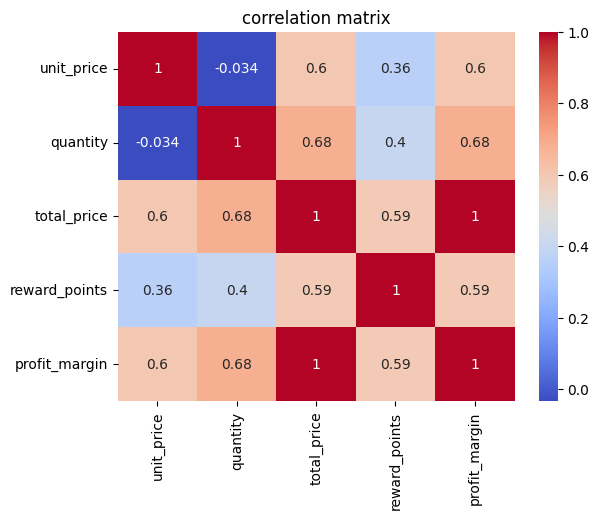

In [94]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns


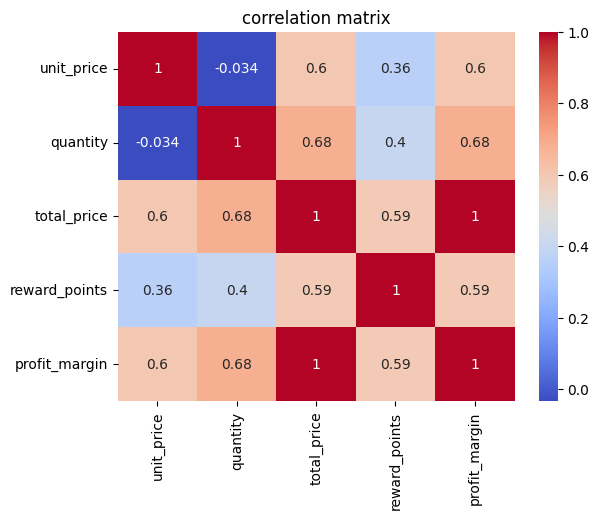

In [95]:
#correlation analysis
corr=df[['unit_price','quantity','total_price','reward_points','profit_margin']].corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title("correlation matrix")
plt.show()

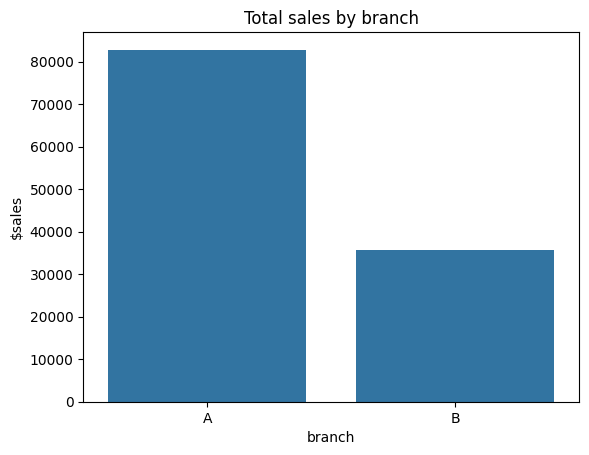

In [96]:
branch_sales=df.groupby('branch')['total_price'].sum().sort_values(ascending=False)
sns.barplot(x=branch_sales.index,y=branch_sales.values)
plt.title("Total sales by branch")
plt.ylabel("$sales")
plt.show()

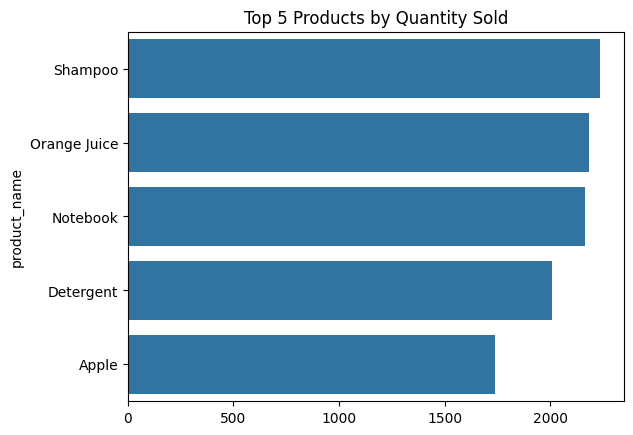

In [97]:
top_products = df.groupby("product_name")["quantity"].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 5 Products by Quantity Sold")
plt.show()

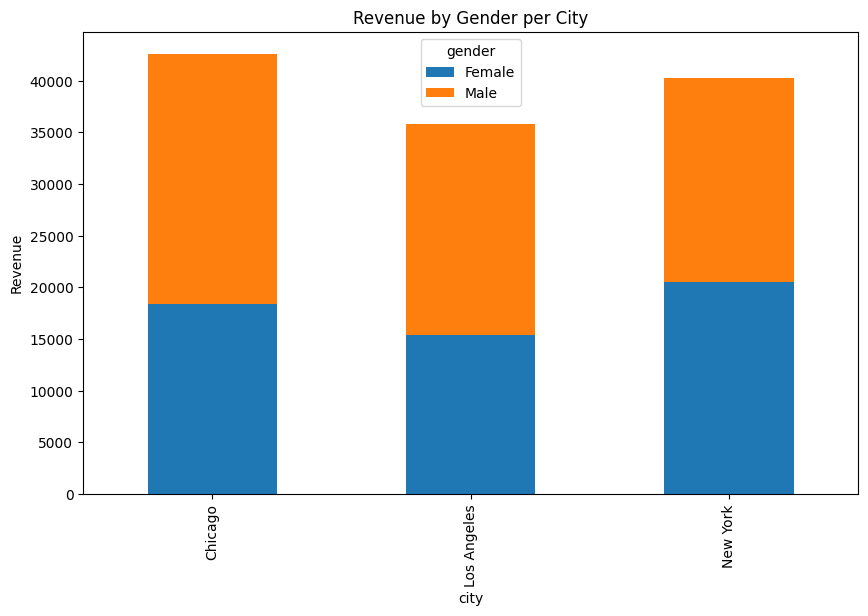

In [104]:
gender_city = df.groupby(["city", "gender"])["total_price"].sum().unstack().fillna(0)
gender_city.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Revenue by Gender per City")
plt.ylabel("Revenue")
plt.show()

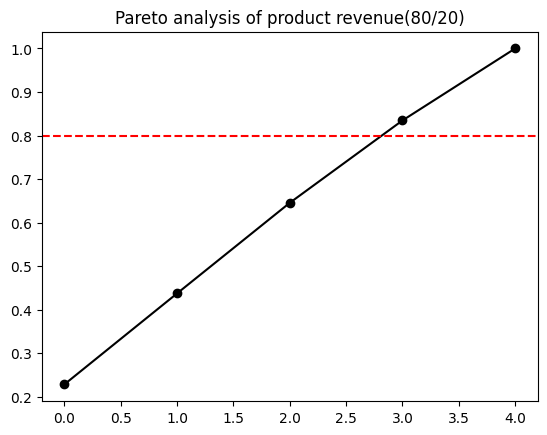

In [115]:
#pareto analysis
product_revenue=df.groupby('product_name')['total_price'].sum().sort_values(ascending=False)
cumulative=product_revenue.cumsum()/product_revenue.sum()
plt.plot(cumulative.values,marker='o',color='black')
plt.axhline(0.8,color='red',linestyle='--')
plt.title("Pareto analysis of product revenue(80/20)")
plt.show()

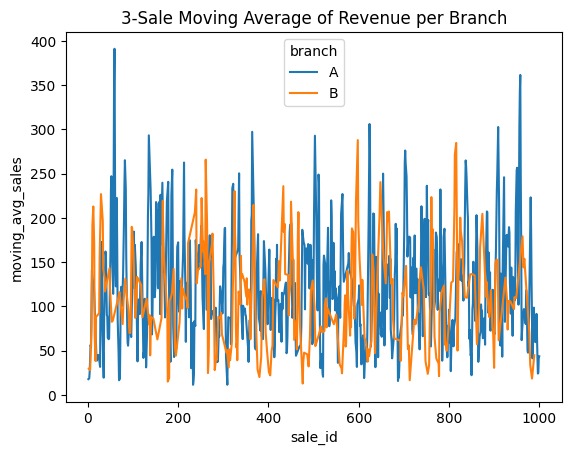

In [120]:
df["moving_avg_sales"] = df.groupby("branch")["total_price"].transform(lambda x: x.rolling(3, min_periods=1).mean())

sns.lineplot(data=df, x="sale_id", y="moving_avg_sales", hue="branch")
plt.title("3-Sale Moving Average of Revenue per Branch")
plt.show()

df

In [121]:
df

,sale_id,branch,city,customer_type,gender,product_name,product_category,unit_price,quantity,tax,total_price,reward_points,cost_estimate,profit_margin,ponits_efficiency,moving_avg_sales
0,1,A,New York,Member,Male,Shampoo,Personal Care,5.50,3,1.16,17.66,1,11.550,6.110,0.056625,17.660000
1,2,B,Los Angeles,Normal,Female,Notebook,Stationery,2.75,10,1.93,29.43,0,19.250,10.180,0.000000,29.430000
2,3,A,New York,Member,Female,Apple,Fruits,1.20,15,1.26,19.26,1,12.600,6.660,0.051921,18.460000
3,4,A,Chicago,Normal,Male,Detergent,Household,7.80,5,2.73,41.73,0,27.300,14.430,0.000000,26.216667
4,5,B,Los Angeles,Member,Female,Orange Juice,Beverages,3.50,7,1.72,26.22,2,17.150,9.070,0.076278,27.825000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,A,New York,Member,Female,Shampoo,Stationery,1.55,11,1.19,18.24,1,11.935,6.305,0.054825,41.776667
996,997,A,New York,Member,Male,Detergent,Personal Care,2.44,7,1.20,18.28,1,11.956,6.324,0.054705,23.943333
997,998,A,New York,Member,Female,Shampoo,Stationery,17.92,2,2.51,38.35,3,25.088,13.262,0.078227,24.956667
998,999,A,New York,Member,Female,Shampoo,Beverages,17.41,4,4.87,74.51,7,48.748,25.762,0.093947,43.713333


In [126]:
df.to_csv("cleaned_sales.csv",index=False)